<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/330_beta_binomial.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(mcmc-bayes-inference-notebook)=
# Inferenza bayesiana con PyMC

In questo capitolo, useremo PyMC, una libreria Python dedicata alla modellazione statistica bayesiana. A differenza del capitolo precedente, in cui abbiamo fatto uso delle funzioni di scipy.stats, qui adotteremo un Linguaggio di Programmazione Probabilistico (PPL) per creare il nostro campionatore. I PPL consentono di definire i modelli bayesiani direttamente attraverso il codice del PPL stesso, semplificando notevolmente l'esecuzione dell'inferenza bayesiana in modo altamente automatizzato. Questo approccio permette agli utenti di concentrarsi sulla costruzione dei modelli, liberandoli dai dettagli matematici e computazionali.

## Campionatore No-U-Turn

L'algoritmo Metropolis, che abbiamo esaminato in precedenza, offre un metodo per generare campioni da distribuzioni di probabilità attraverso la creazione di una catena di Markov, con la distribuzione desiderata come distribuzione di equilibrio (o stazionaria). Tuttavia, per modelli complessi, tale algoritmo può risultare inefficiente e richiedere un considerevole tempo per convergere verso una distribuzione stazionaria. Per affrontare questa sfida, sono stati sviluppati algoritmi Monte Carlo a catena di Markov (MCMC) più efficienti, tra cui il campionatore No-U-Turn (NUTS), gli algoritmi Metropolis-Hastings, il campionatore Gibbs e il campionatore Hamiltonian Monte Carlo. Questi algoritmi sono stati implementati in vari framework per la programmazione probabilistica (PP), noti come "Universal Inference Engines". Tra i più noti, troviamo PyMC e Stan {cite}`carpenter2017stan`.

PyMC è un linguaggio di programmazione probabilistica ampiamente utilizzato che consente di definire modelli complessi, anche con un grande numero di parametri, attraverso una sintassi chiara e intuitiva. In questo capitolo, useremo PyMC per condurre l'inferenza sulle proporzioni binomiali, sfruttando il campionamento Monte Carlo a catena di Markov.

Iniziamo a caricare i pacchetti necessari.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

from aquarel import load_theme
theme = load_theme("minimal_light")
theme.apply()
sns.set_palette("colorblind")

Un esempio pratico di utilizzo del linguaggio probabilistico PyMC consiste nell'eseguire una semplice operazione aritmetica. Iniziamo a sommare due numeri interi in Python.

In [4]:
# adding 2 integers in Python
a = 2
b = 3
c = a + b
print(c)

5


Facciamo ora la stessa cosa usando PyMC.

In [5]:
# adding 2 random variables in PyMC
with pm.Model() as example:
    a = pm.Normal("a", 2, 0.5)
    b = pm.Normal("b", 3, 0.2)
    c = pm.Deterministic("c", a + b)
    trace_1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


Il risultato che otteniamo è una distribuzione di probabilità di $c$. Dalla figura vediamo che la moda della distribuzione di $c$ è uguale al risultato atteso. 

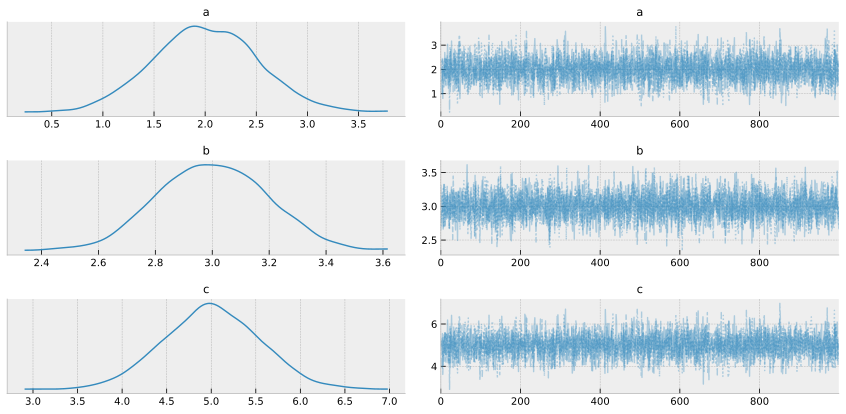

In [11]:
az.plot_trace(trace_1, compact=True, combined=True)
plt.tight_layout();

## Generazione X

Esaminiamo ora un caso di inferenza basato su dati reali, a differenza della situazione deterministica esaminata precedentemente. Consideriamo come esempio nuovamente i dati discussi nel capitolo precedente e relativi agli artisti della Generazione X nel MOMA. Ricordiamo che abbiamo osservato 14 successi su 100 prove e che abbiamo imposto sul parametro $\theta$ (probabilità di appartenere alla Generazione X o successive) una Beta(4, 6). 

Il modello, dunque, si presenta come:

$$
\begin{align}
y &\sim Bin(n, \theta) \notag\\
\theta &\sim Beta(4, 6)
\end{align}
$$ 

In questa formulazione, la prima riga definisce la funzione di verosimiglianza, mentre la seconda riga stabilisce la distribuzione a priori.

Nel caso specifico affrontato, è possibile ottenere una soluzione analitica per stimare la distribuzione a posteriori, evitando quindi l'utilizzo dei Metodi di Monte Carlo a Catena di Markov (MCMC). Ad esempio, nel caso in cui $y$ = 14 e $n$ = 100, la distribuzione a posteriori assume la forma di una Beta(18, 92). 

Anche se in questo specifico caso siamo in grado di ottenere una soluzione analitica per la distribuzione a posteriori, nella maggior parte dei modelli di inferenza bayesiana questa opportunità è rara. Spesso, per gestire modelli più complessi, diventa necessario adottare tecniche di approssimazione numerica come i metodi MCMC. In questo esempio, applicheremo i MCMC a un caso in cui abbiamo già accesso alla soluzione analitica. Questo ci consentirà di confrontare i risultati ottenuti tramite l'approccio analitico con quelli ottenuti attraverso l'approssimazione numerica.

### Dedurre una proporzione con PyMC

Adesso eseguiremo l'analisi che abbiamo precedentemente condotto utilizzando il metodo numerico Markov Chain Monte Carlo (MCMC). Assumiamo di avere già installato il pacchetto PyMC. Una volta installato, dovremo importare le librerie necessarie, tra cui Matplotlib, Numpy, Scipy, Arviz e ovviamente PyMC stesso.

Esamineremo ora come specificare il modello beta-binomiale attraverso PyMC. Per condurre l'analisi tramite PyMC, sarà prima necessario delineare la struttura del modello bayesiano e, successivamente, eseguire il campionamento dalla distribuzione a posteriori. Approfondiremo entrambi questi passaggi nell'ambito del nostro esempio.

### Dati

In [3]:
y = 14
ntrials = 100

### Distribuzione a priori

I parametri della distribuzione Beta, scelta come distribuzione a priori per $\theta$, sono i seguenti.

In [4]:
alpha_prior = 4
beta_prior = 6

### Definire il modello

Nella specifica del modello tramite PyMC, si fa uso del costrutto `with` di Python. Questo ci permette di definire tutti i parametri, gli argomenti e i valori iniziali all'interno di un'istanza di `pymc.Model`, che in questo caso chiameremo `bb_model`.

In [6]:
bb_model = pm.Model()

with bb_model:
    # Prior
    theta = pm.Beta("theta", alpha=alpha_prior, beta=beta_prior)
    # Likelihood
    obs = pm.Binomial("obs", p=theta, n=ntrials, observed=y)

La prima linea di codice:

```python
bb_model = pm.Model()
```

crea un nuovo oggetto della classe `Model`, che funziona come un contenitore per le variabili casuali del modello. Dopo aver istanziato il modello, la successiva specifica delle componenti del modello viene eseguita all'interno di un blocco di codice `with:`.

Questo blocco crea un *context manager*, con `bb_model` come contesto, e include tutte le istruzioni all'interno dell'indentazione. In pratica, tutto ciò che è introdotto nel blocco di codice indentato sotto l'istruzione `with:` viene automaticamente aggiunto al modello. Senza questo meccanismo del *context manager*, saremmo costretti a associare manualmente ogni variabile a `bb_model`.

Con la chiamata al costruttore `pm.Beta`, creiamo una variabile casuale da utilizzare come distribuzione a priori. Il primo argomento è il nome della variabile casuale, che dovrebbe coincidere con il nome della variabile Python assegnata. Questo nome spesso viene utilizzato per recuperare la variabile dal modello e riepilogarne l'output. I restanti argomenti richiesti per un oggetto stocastico sono i parametri, in questo caso `alpha` e `beta`, ai quali assegniamo i valori degli iperparametri del modello. Nell'esempio, i valori `alpha_prior` e `beta_prior` sono assegnati come parametri della distribuzione Beta a priori.

L'ultima riga del modello definisce `obs`, la distribuzione campionaria della variabile di outcome nei dati. Questo è un caso speciale di variabile stocastica chiamata `observed stochastic`, che rappresenta la verosimiglianza dei dati nel modello. Anche se è simile alle altre variabili stocastiche, la differenza sta nell'argomento `obs`, che indica che i valori di questa variabile sono stati osservati e non devono essere modificati dal modello. I dati possono essere passati come oggetti `ndarray` o `DataFrame`. Nel nostro caso, nella funzione di verosimiglianza Binomiale, specifichiamo il parametro `p=theta`, il numero di prove `n=ntrials` e il numero di successi `observed=y`.

Da notare che, a differenza delle distribuzioni a priori del modello, i parametri della distribuzione Beta di `obs` non sono valori fissi, ma sono legati all'oggetto stocastico `theta`. Questa relazione tra genitore (la variabile `theta`) e figlio (`obs`) viene automaticamente gestita dal sistema.

### Esecuzione del campionamento

Abbiamo già esaminato un esempio di campionamento MCMC quando abbiamo discusso l'algoritmo Metropolis. PyMC semplifica questa procedura. Nel contesto attuale, stiamo eseguendo il campionamento MCMC utilizzando l'algoritmo predefinito (NUTS), che rappresenta una variante dell'algoritmo Metropolis. I risultati del campionamento vengono salvati nell'oggetto `idata`.

In [17]:
with bb_model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


La funzione `sample` esegue il metodo `step` assegnato (o quello fornito) per il numero di iterazioni specificato (in questo caso, 2000 iterazioni dopo un periodo iniziale di *burn-in* di 1000 iterazioni) e restituisce un oggetto `InferenceData` contenente i campioni raccolti, insieme ad altri attributi utili come le statistiche del campionamento e una copia dei dati osservati.

È da sottolineare che `sample` genera una serie di catene parallele, a seconda del numero di *core* di calcolo presenti sulla macchina. Nell'ambito della mia macchina, che dispone di 4 core, vengono eseguite 4 catene in parallelo. Come indicato dal messaggio prodotto da `sample`, questo processo restituisce 8000 campioni casuali dalla distribuzione a posteriori dopo un iniziale periodo di *burn-in* di 4000 iterazioni.

L'oggetto `InferenceData` rappresenta un formato dati progettato appositamente per le analisi bayesiane MCMC. La sua funzione principale è agevolare l'archiviazione e la manipolazione delle informazioni generate durante un processo bayesiano, inclusi i campioni dalle distribuzioni a posteriori, la distribuzione a priori, le distribuzioni predittive a posteriori, le distribuzioni predittive a priori e altre informazioni e diagnostiche generate durante il campionamento.

Il formato `InferenceData` si basa su xarray, una libreria che offre strutture dati N-dimensionali etichettate (una generalizzazione sia delle matrici Numpy che dei dataframe Pandas). Per imparare come eseguire operazioni comuni con `InferenceData`, come l'indicizzazione o la selezione, è possibile consultare questa [pagina web](https://python.arviz.org/en/0.14.0/getting_started/WorkingWithInferenceData.html).

Poiché abbiamo stabilito una distribuzione a priori per il parametro $\theta$, l'algoritmo procede in modo iterativo, adattando la distribuzione a priori di $\theta$ in base ai valori precedentemente generati. Dopo un certo numero di iterazioni, necessario per raggiungere la convergenza dell'algoritmo, i valori estratti possono essere considerati come campioni dalla distribuzione a posteriori di $\theta$.

Con l'aumento delle iterazioni della catena, l'approssimazione della distribuzione target (cioè la distribuzione a posteriori) migliora gradualmente. Tuttavia, all'inizio del campionamento, la distribuzione potrebbe essere notevolmente lontana da quella stazionaria. Si verifica un periodo iniziale di *burn-in*, durante il quale i campioni provenienti da questa fase vengono tipicamente scartati poiché potrebbero non riflettere accuratamente la distribuzione a posteriori.

La durata complessiva del processo di campionamento dipende dalla potenza di calcolo del computer.

Una rappresentazione grafica della distribuzione a posteriori di $\theta$ può essere ottenuta con `plot_posterior`.

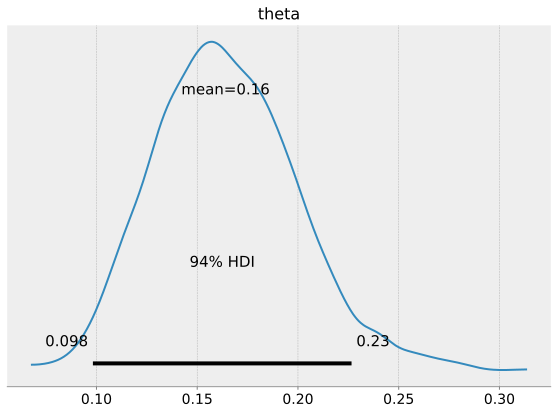

In [28]:
az.plot_posterior(idata);

### Utilizzo dell'Algoritmo Metropolis

Se vogliamo optare per l'utilizzo dell'algoritmo di campionamento Metropolis anziché NUTS, che rappresenta l'impostazione predefinita, possiamo specificarlo come argomento "step" per la funzione "sample".

In [7]:
with bb_model:
    metropolis_idata = pm.sample(step=pm.Metropolis())

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


La distribuzione a posteriori è praticamente identica a quella ottenuta in precedenza.

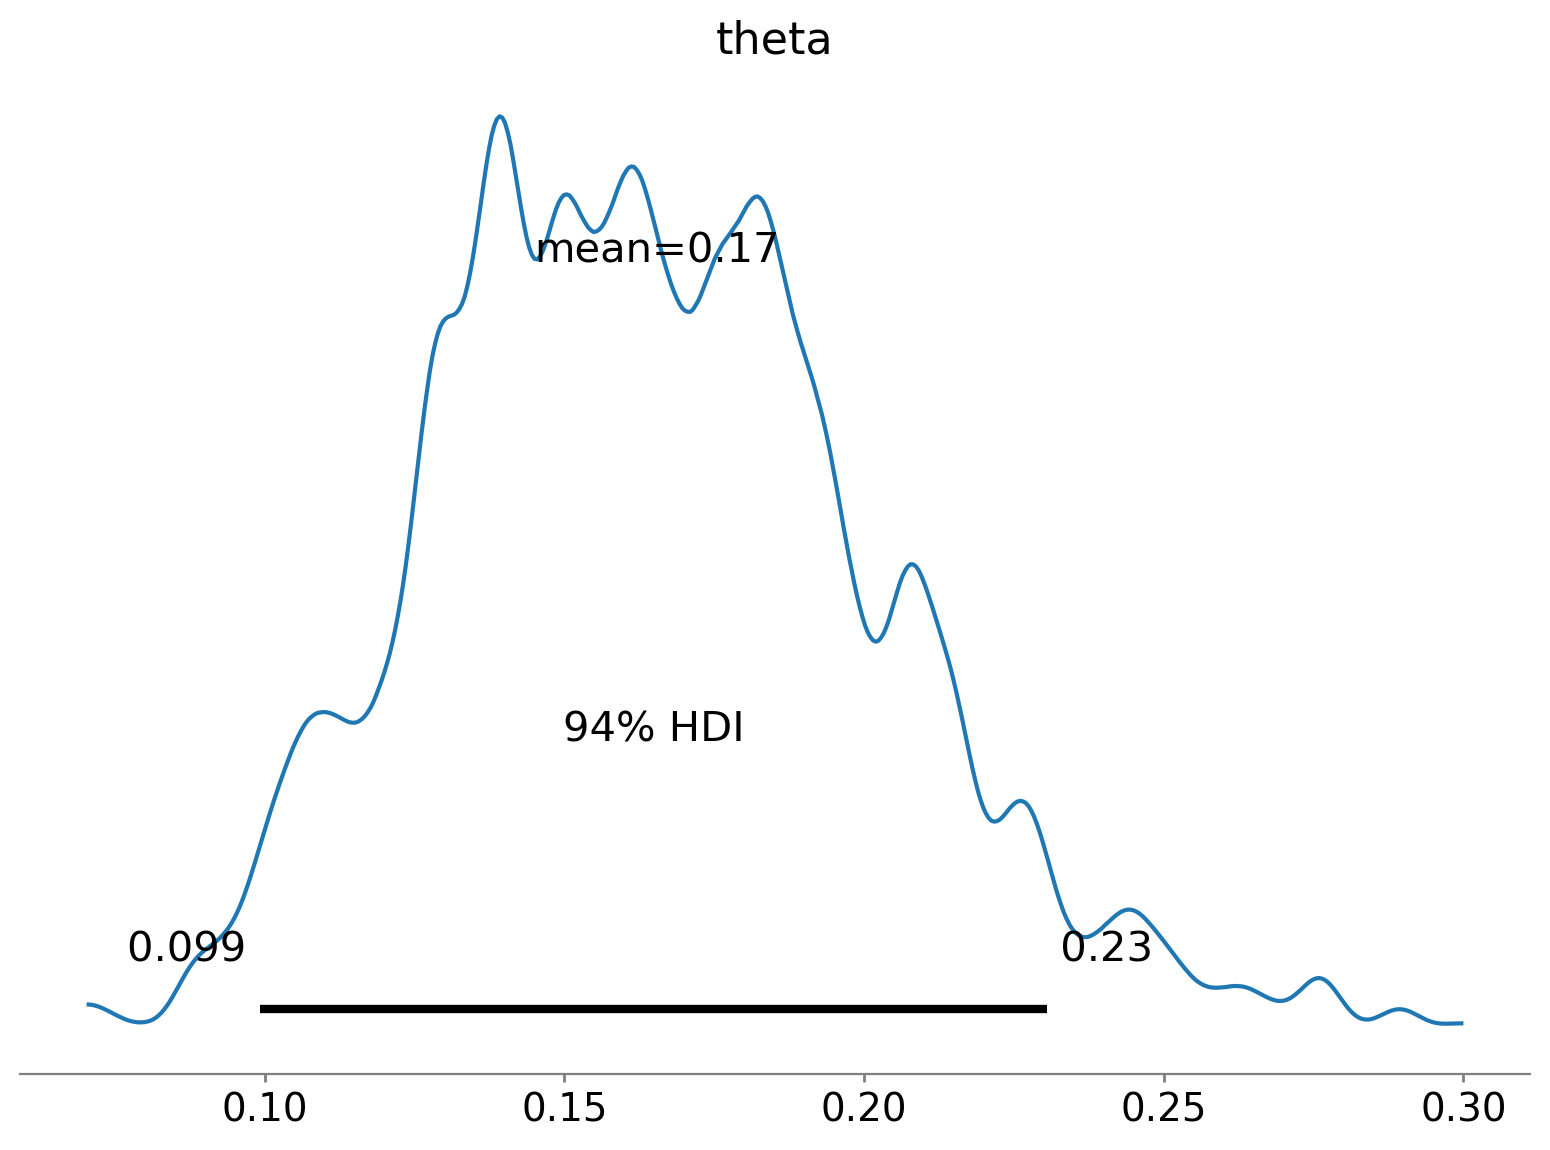

In [8]:
az.plot_posterior(metropolis_idata);

Esaminiamo l'accettanza.

Un tracciato della catena di Markov illustra questa esplorazione rappresentando il valore $\theta$ sulle ordinate e l'indice progressivo di in ogni iterazione sull'ascissa. Il trace plot è estremamente utile per valutare la convergenza di un algoritmo MCMC e se è necessario escludere un periodo di campioni iniziali (noto come burn-in). Per produrre la traccia chiamiamo semplicemente `az.plot_trace()` con la variabile `idata`:

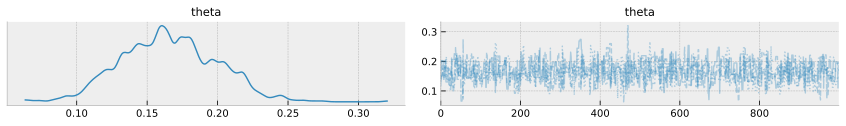

In [21]:
az.plot_trace(metropolis_idata, combined=True);

Per combinare catene e iterazioni, utilizziamo la funzione `arviz.extract()`. Creiamo un oggetto `DataArray` di Xarray chiamato `post`.

In [22]:
post = az.extract(metropolis_idata)

Nella figura successiva sono presentate sia la distribuzione a posteriori ottenuta tramite il metodo MCMC, sia quella derivata analiticamente. 

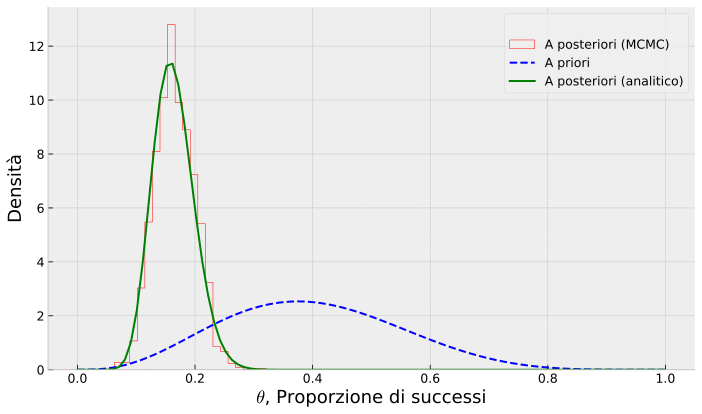

In [23]:
p_post = post["theta"]

# Posterior: Beta(alpha + y, beta + n - y)
alpha_post = alpha_prior + y
beta_post = beta_prior + ntrials - y

plt.hist(
    p_post,
    bins=20,
    histtype="step",
    density=True,
    label="A posteriori (MCMC)",
    color="C0",
)

# Plot the analytic prior and posterior beta distributions
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, alpha_prior, beta_prior), "--", label="A priori", color="C1")
plt.plot(
    x,
    stats.beta.pdf(x, alpha_post, beta_post),
    label="A posteriori (analitico)",
    color="C2",
)

# Update the graph labels
plt.legend(title=" ", loc="best")
plt.xlabel("$\\theta$, Proporzione di successi")
plt.ylabel("Densità");

Si può osservare la coerenza tra le due soluzioni: l'istogramma segue da vicino la distribuzione a posteriori calcolata analiticamente, come da previsione.

## Commenti e considerazioni finali 

Questo capitolo ha illustrato come utilizzare PyMC per ottenere la distribuzione a posteriori quando ci troviamo di fronte a un caso di distribuzione beta-binomiale, caratterizzato dalle relazioni di verosimiglianza binomiale e dalla distribuzione a priori Beta. Inoltre, è stata condotta un'analisi comparativa tra la soluzione ottenuta tramite PyMC e la soluzione analitica del problema discusso, dimostrando la convergenza tra i due approcci.

## Watermark

In [30]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Jul 15 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.12.0

seaborn   : 0.12.2
pymc      : 5.6.1
pandas    : 1.5.3
scipy     : 1.10.1
arviz     : 0.16.0
matplotlib: 3.7.1
numpy     : 1.25.0

Watermark: 2.4.3

